# Generative Adversarial Network
This code is based on the code given by [this collab
code](https://bit.ly/39Wwirg). It was organized and modify to suit the author's
needs.

## Authors
- David Plazas Escudero
- Juan Sebastián Cárdenas-Rodríguez

## Global Behavior.


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython import display
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from tqdm.autonotebook import tqdm

%matplotlib inline
rc('text', usetex=True)


## Parameters of Training


In [3]:
# Sample sizes
TRAIN_BUF = 60000
TEST_BUF = 10000

# Image dimensions
DIMS = (28,28,1)

# Batch information
BATCH_SIZE = 512
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

# Seed
tf.random.set_seed(123456789)


## MNIST Dataset


In [4]:
# Load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

# Split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32" ) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28,
                                  1).astype("float32") / 255.0

# Batch datasets
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(TRAIN_BUF).batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(TEST_BUF).batch(BATCH_SIZE))


11493376/11490434 [==============================] - 2s 0us/step


## Define GAN Network
Abstract class for GAN.


In [5]:
class GAN (tf.keras.Model):
    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        # Generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # Run noise through generator
        x_gen = self.generate(z_samp)

        # Discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)

        ## Losses
        # Losses of real with label "1"
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)

        # Losses of fake with label "0"
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss

        # Losses of fake with label "1"
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        ## Pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # Compute gradients
        gen_gradients = gen_tape.gradient(gen_loss,
                                          self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss,
                                            self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):
        self.gen_optimizer.apply_gradients(zip(gen_gradients,
                                               self.gen.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(disc_gradients,
                                                self.disc.trainable_variables))
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)


# Gan Loss
def gan_loss(logits, is_real=True):
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(multi_class_labels=labels,
                                                     logits=logits)


### Define the network architecture


In [7]:
N_Z = 64

# Generator
generator = [tf.keras.layers.Dense(units=7 * 7 * N_Z, activation="relu"),
             tf.keras.layers.Reshape(target_shape=(7, 7, N_Z)),
             tf.keras.layers.Conv2DTranspose(filters=N_Z, kernel_size=3,
                                             strides=(2, 2), padding="SAME",
                                             activation="relu"),
             tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3,
                                             strides=(2, 2), padding="SAME",
                                             activation="relu"),
             tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3,
                                             strides=(1, 1), padding="SAME",
                                             activation="sigmoid" ),]

# Discriminator
discriminator = [tf.keras.layers.InputLayer(input_shape=DIMS),
                 tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2),
                                          activation="relu"),
                 tf.keras.layers.Conv2D( filters=64, kernel_size=3, strides=(2, 2),
                                         activation="relu" ),
                 tf.keras.layers.Flatten(),
                 tf.keras.layers.Dense(units=1, activation=None)]


In [8]:
# Optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)

# Model
model = GAN(gen = generator, disc = discriminator, gen_optimizer =
            gen_optimizer, disc_optimizer = disc_optimizer, n_Z = N_Z)

## Training


In [12]:
# Fixed noise for video generation
nums = tf.random.normal(shape=(BATCH_SIZE, N_Z))

# Plotting some reconstructions
def plot_reconstruction(model, nums, nex=8, zm=2, nr=3, nc=4, show=True):
    samples = model.generate(nums)
    aux = 0
    for axix in range(nr):
      for axiy in range(nc):
        axs[axix, axiy].matshow(samples.numpy()[aux].squeeze(),
                               cmap=plt.cm.Greys_r, vmin=0, vmax=1)
        axs[axix, axiy].axis('off')
        aux += 1
    if show:
      plt.show()
    return axs


In [10]:
# Dataframe with losses
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])


## Training algorithm


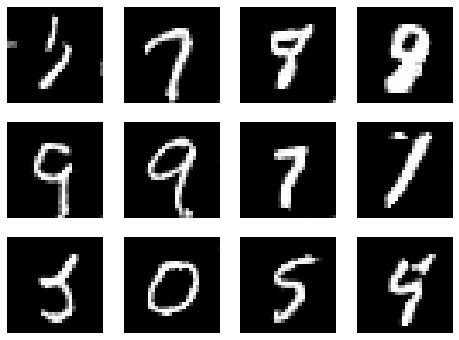

In [15]:
def anim(i):
    # Train
    for batch, train_x in zip(range(N_TRAIN_BATCHES), train_dataset):
        model.train(train_x)

    # Calculate losses
    loss = []
    for batch, test_x in zip(range(N_TEST_BATCHES), test_dataset):
        loss.append(model.compute_loss(test_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)

    # Plot results
    axs = plot_reconstruction(model, nums, nex=12, show=False)
    return axs

# Video parameters
zm = 2      # Figure size parameter
nex = 12    # Number of examples
nr = 3      # Number of rows in plot

# Video generation
nc = int(np.ceil(nex/nr))
fig, axs = plt.subplots(ncols=nc, nrows=nr, figsize=(zm * nc, zm * nr))
desired_time = 10
epochs = 150
ani = FuncAnimation(fig, anim, frames=epochs,
                    interval=int(1000*desired_time/epochs))
ani.save("../results/gan-evolution.mp4")


## Loss Plot


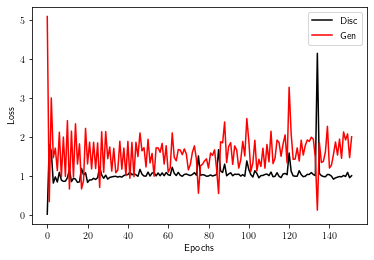

In [18]:
plt.plot(losses["disc_loss"], 'k', label="Disc")
plt.plot(losses["gen_loss"], 'r', label="Gen")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("../article/figs/loss-GAN.pdf", bbox_inches='tight')
plt.show()
